In [1]:
import tensorflow as tf
import numpy as np
from time import time
from utils import plot_images, read_mnist_data
from tfops import fc, inflate, flatten, conv, deconv
from os.path import exists
import cifar10
from tensorflow.contrib.layers import batch_norm

In [2]:
#data, _ = read_mnist_data()
#data_train = data.train.images
#data_test = data.test.images
cifar10.maybe_download_and_extract()
data_train, data_train_cls, _ = cifar10.load_training_data()
data_test, _, _ = cifar10.load_test_data()

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [3]:
def generator(z):
    x_gen = fc(z, 128 * 8 * 8, 'relu', 'fc1')
    x_gen = inflate(x_gen, (8, 8))
    x_gen = deconv(x_gen, 64, out_shape=(-1, 16, 16, -1), name='tconv1')
    return deconv(x_gen, 3, activation='tanh', out_shape=(-1, 32, 32, -1), name='tconv2')

In [4]:
def discriminator(img):
    p = conv(img, 64, 'lrelu', name='conv1')
    p = conv(p, 128, 'lrelu', name='conv2')
    p = flatten(p, 'flatten')
    return fc(p, 1, 'sigmoid', 'fc2')

In [5]:
def log(_in, name=None):
    return tf.log(tf.maximum(1e-5, _in), name)

In [19]:
z_dim = 128

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 32, 32, 3), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    
with tf.variable_scope('generator'):
    x_gen = generator(z) 
    
with tf.variable_scope('discriminator'):
    p_x = discriminator(x)
    tf.get_variable_scope().reuse_variables()
    p_g = discriminator(x_gen)
    
    
with tf.name_scope('optimizer'):
    loss_g = -tf.reduce_mean(log(p_g))
    loss_d = -tf.reduce_mean(log(p_x)) - tf.reduce_mean(log(1 - p_g))
    optimizer_g = tf.train.AdamOptimizer(1e-4).minimize(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimizer_d = tf.train.AdamOptimizer(1e-4).minimize(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))

tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
summ = tf.summary.merge_all()

In [22]:
def plot_generated_images(sess):
    generated_images = sess.run(x_gen, feed_dict={z: np.random.randn(11, z_dim)})
    plot_images(0.5 * generated_images + 0.5)

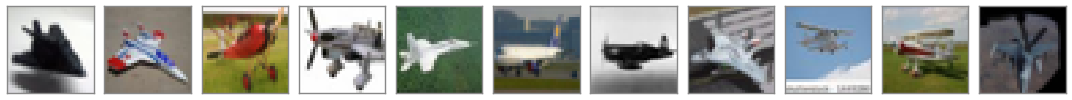

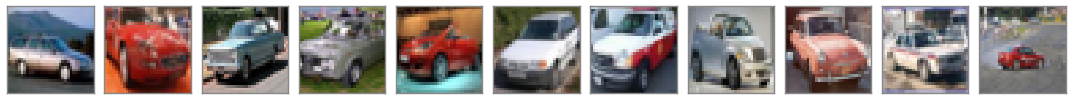

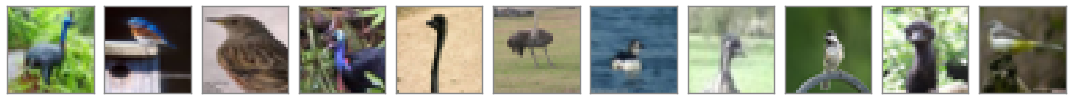

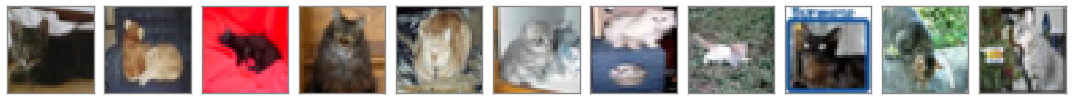

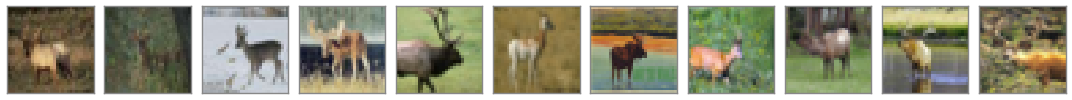

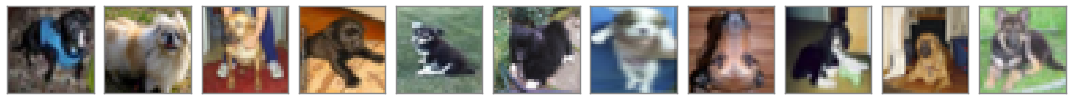

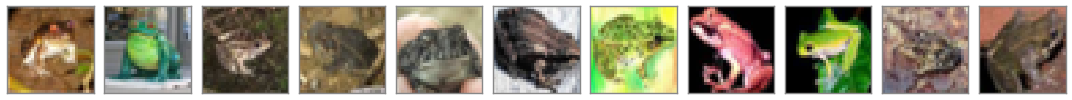

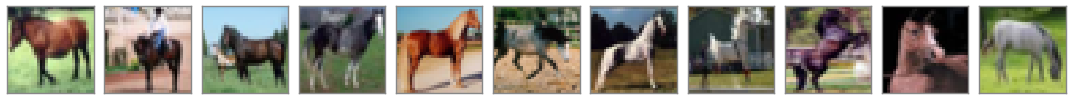

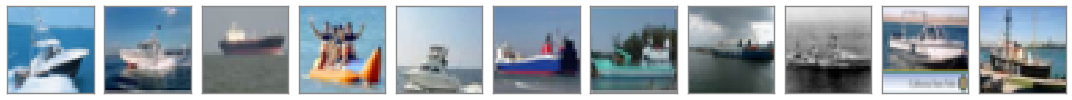

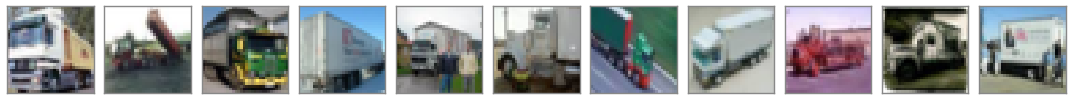

In [21]:
for i in range(10):
    plot_images(data_train[np.where(data_train_cls == i)[0][:11]])

In [23]:
batch_size = 256

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.1

def optimize(epochs=1, category=None):
    start_time = time()
    
    writer = tf.summary.FileWriter('output/DCGAN-CIFAR10', tf.get_default_graph())
    saver = tf.train.Saver()
    
    if category:
        img_cls_idx = np.where(data_train_cls == category)[0]
        data_train_cat = data_train[img_cls_idx]
    else:
        data_train_cat = data_train
    batches_per_epoch = int(len(data_train_cat) / batch_size)
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                img_idx = np.random.choice(range(len(data_train_cat)), batch_size)
                x_batch = data_train_cat[img_idx]
                z_batch = np.random.randn(batch_size, z_dim)
                for _ in range(2):
                    sess.run(optimizer_g, feed_dict={x: 2 * x_batch - 1, z: z_batch})

                sess.run(optimizer_d, feed_dict={x: 2 * x_batch - 1, z: z_batch})

                if batch % 1000 == 0:
                    writer.add_summary(sess.run(summ, feed_dict={x: 2 * x_batch - 1, z: z_batch}), global_step=epoch * batches_per_epoch + batch)
            
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess)
            
        saver.save(sess, 'checkpoints/DCGAN-CIFAR10/DCGAN-CIFAR10', write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-CIFAR10/DCGAN-CIFAR10


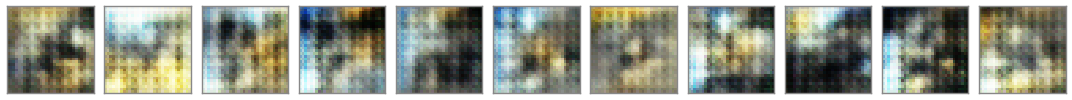

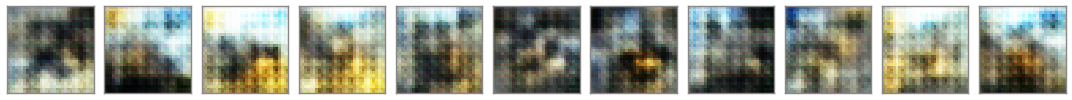

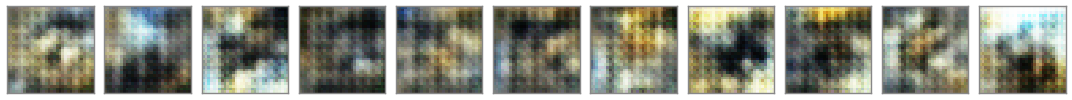

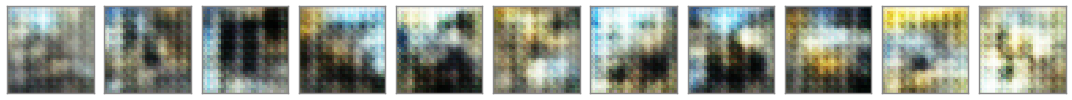

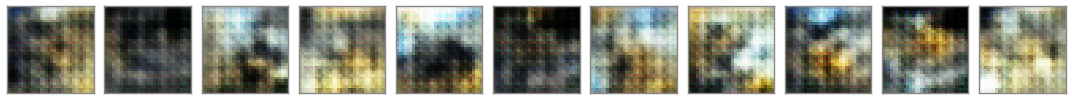

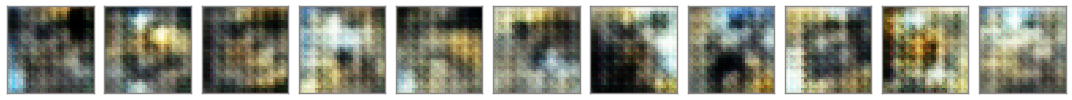

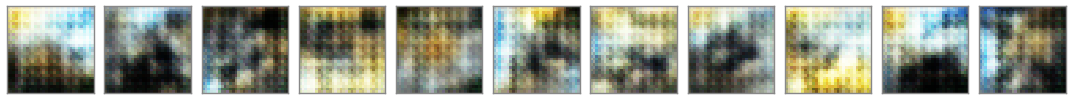

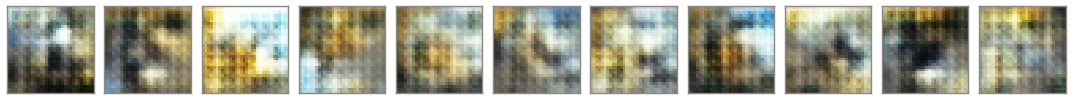

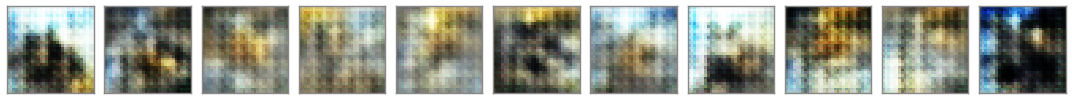

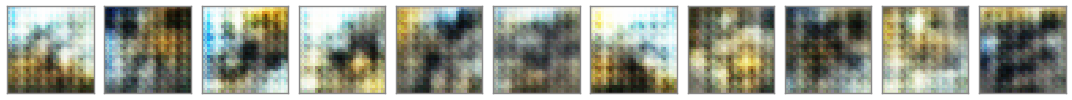

In [25]:
if exists('checkpoints/DCGAN-CIFAR10/DCGAN-CIFAR10.data-00000-of-00001'):
    with tf.Session(config=config) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/DCGAN-CIFAR10/DCGAN-CIFAR10')
        
        for _ in range(10):
            plot_generated_images(sess)
else:
    optimize(30, category=0)